# Classification of Music by Genre

Using features of a music recording, can we develop a model that accurately determines what genre it is? Our dataset offered 11 genres to choose from, and from those, we selected hiphop, blues, and metal to classify.

First, some imports...

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.decomposition import PCA
from collections import Counter

Set up dataset by selecting a variety of attributes to work with and spiltting into test and train data.

In [2]:
music = pd.read_csv("music.csv")
df = music[["Popularity", "danceability", "energy", "loudness", "mode", "speechiness", "acousticness", "liveness", "valence", "tempo", "time_signature", "Class"]]

X = df[["Popularity", "danceability", "energy", "loudness", "mode", "speechiness", "acousticness", "liveness", "valence", "tempo", "time_signature"]]
print(X.shape)
y = df["Class"]
print(y.shape)

classes = {2: "Blues", 5: "HipHop", 8: "Metal"}

X_train, X_test, y_train, y_test = train_test_split(X, y)

(4503, 11)
(4503,)


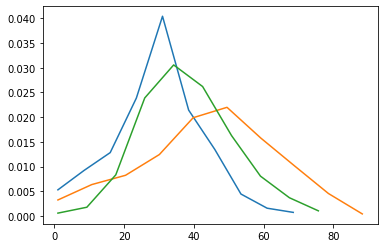

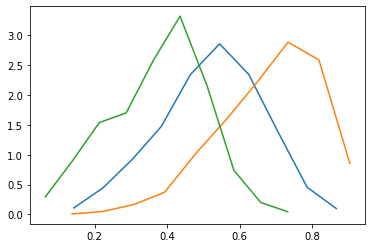

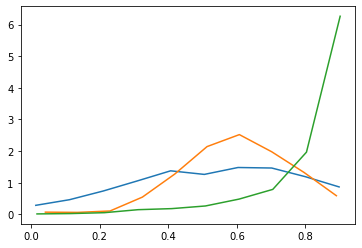

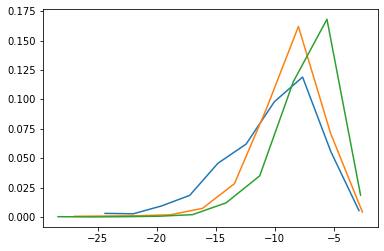

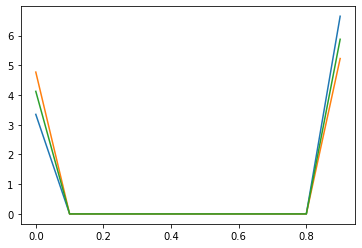

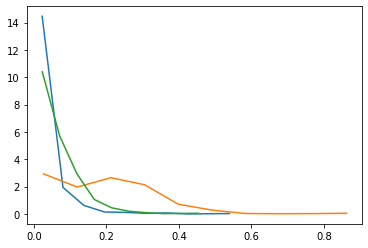

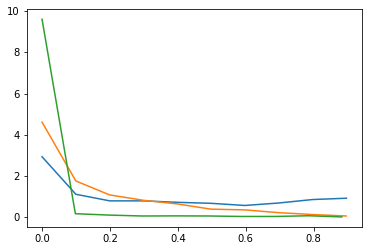

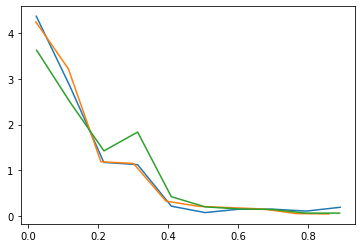

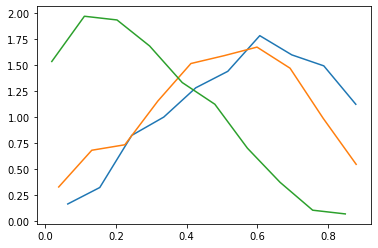

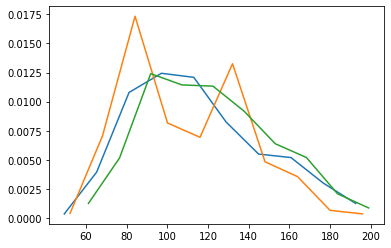

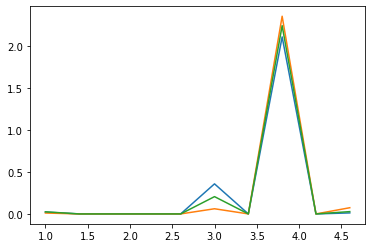

In [3]:
# Graph features as hisograms
blues = df[df.Class == 2]
hiphop = df[df.Class == 5]
metal = df[df.Class == 8]

for cat in ["Popularity", "danceability", "energy", "loudness", "mode", "speechiness", "acousticness", "liveness", "valence", "tempo", "time_signature"]:
    hists = [np.histogram(blues[cat], density=True),
             np.histogram(hiphop[cat], density=True),
             np.histogram(metal[cat], density=True)]
    
    for j in range(len(hists)):
        plt.plot(hists[j][1][:-1], hists[j][0])
    plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2aed89940>,
      dtype=object)

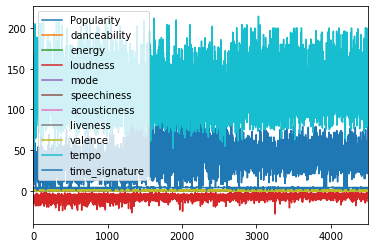

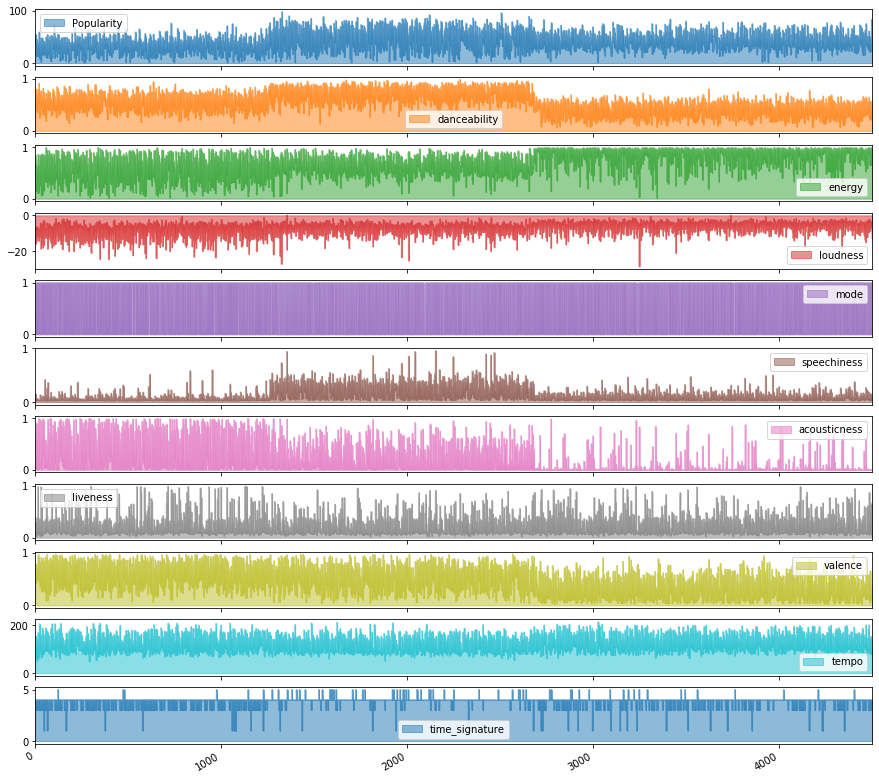

In [4]:
# all classes, by feature (data is sorted by class, so you can see roughly where the class boundaries are)
X.plot()
X.plot.area(figsize=(15, 15), stacked=False, subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2aefb3dd8>,
      dtype=object)

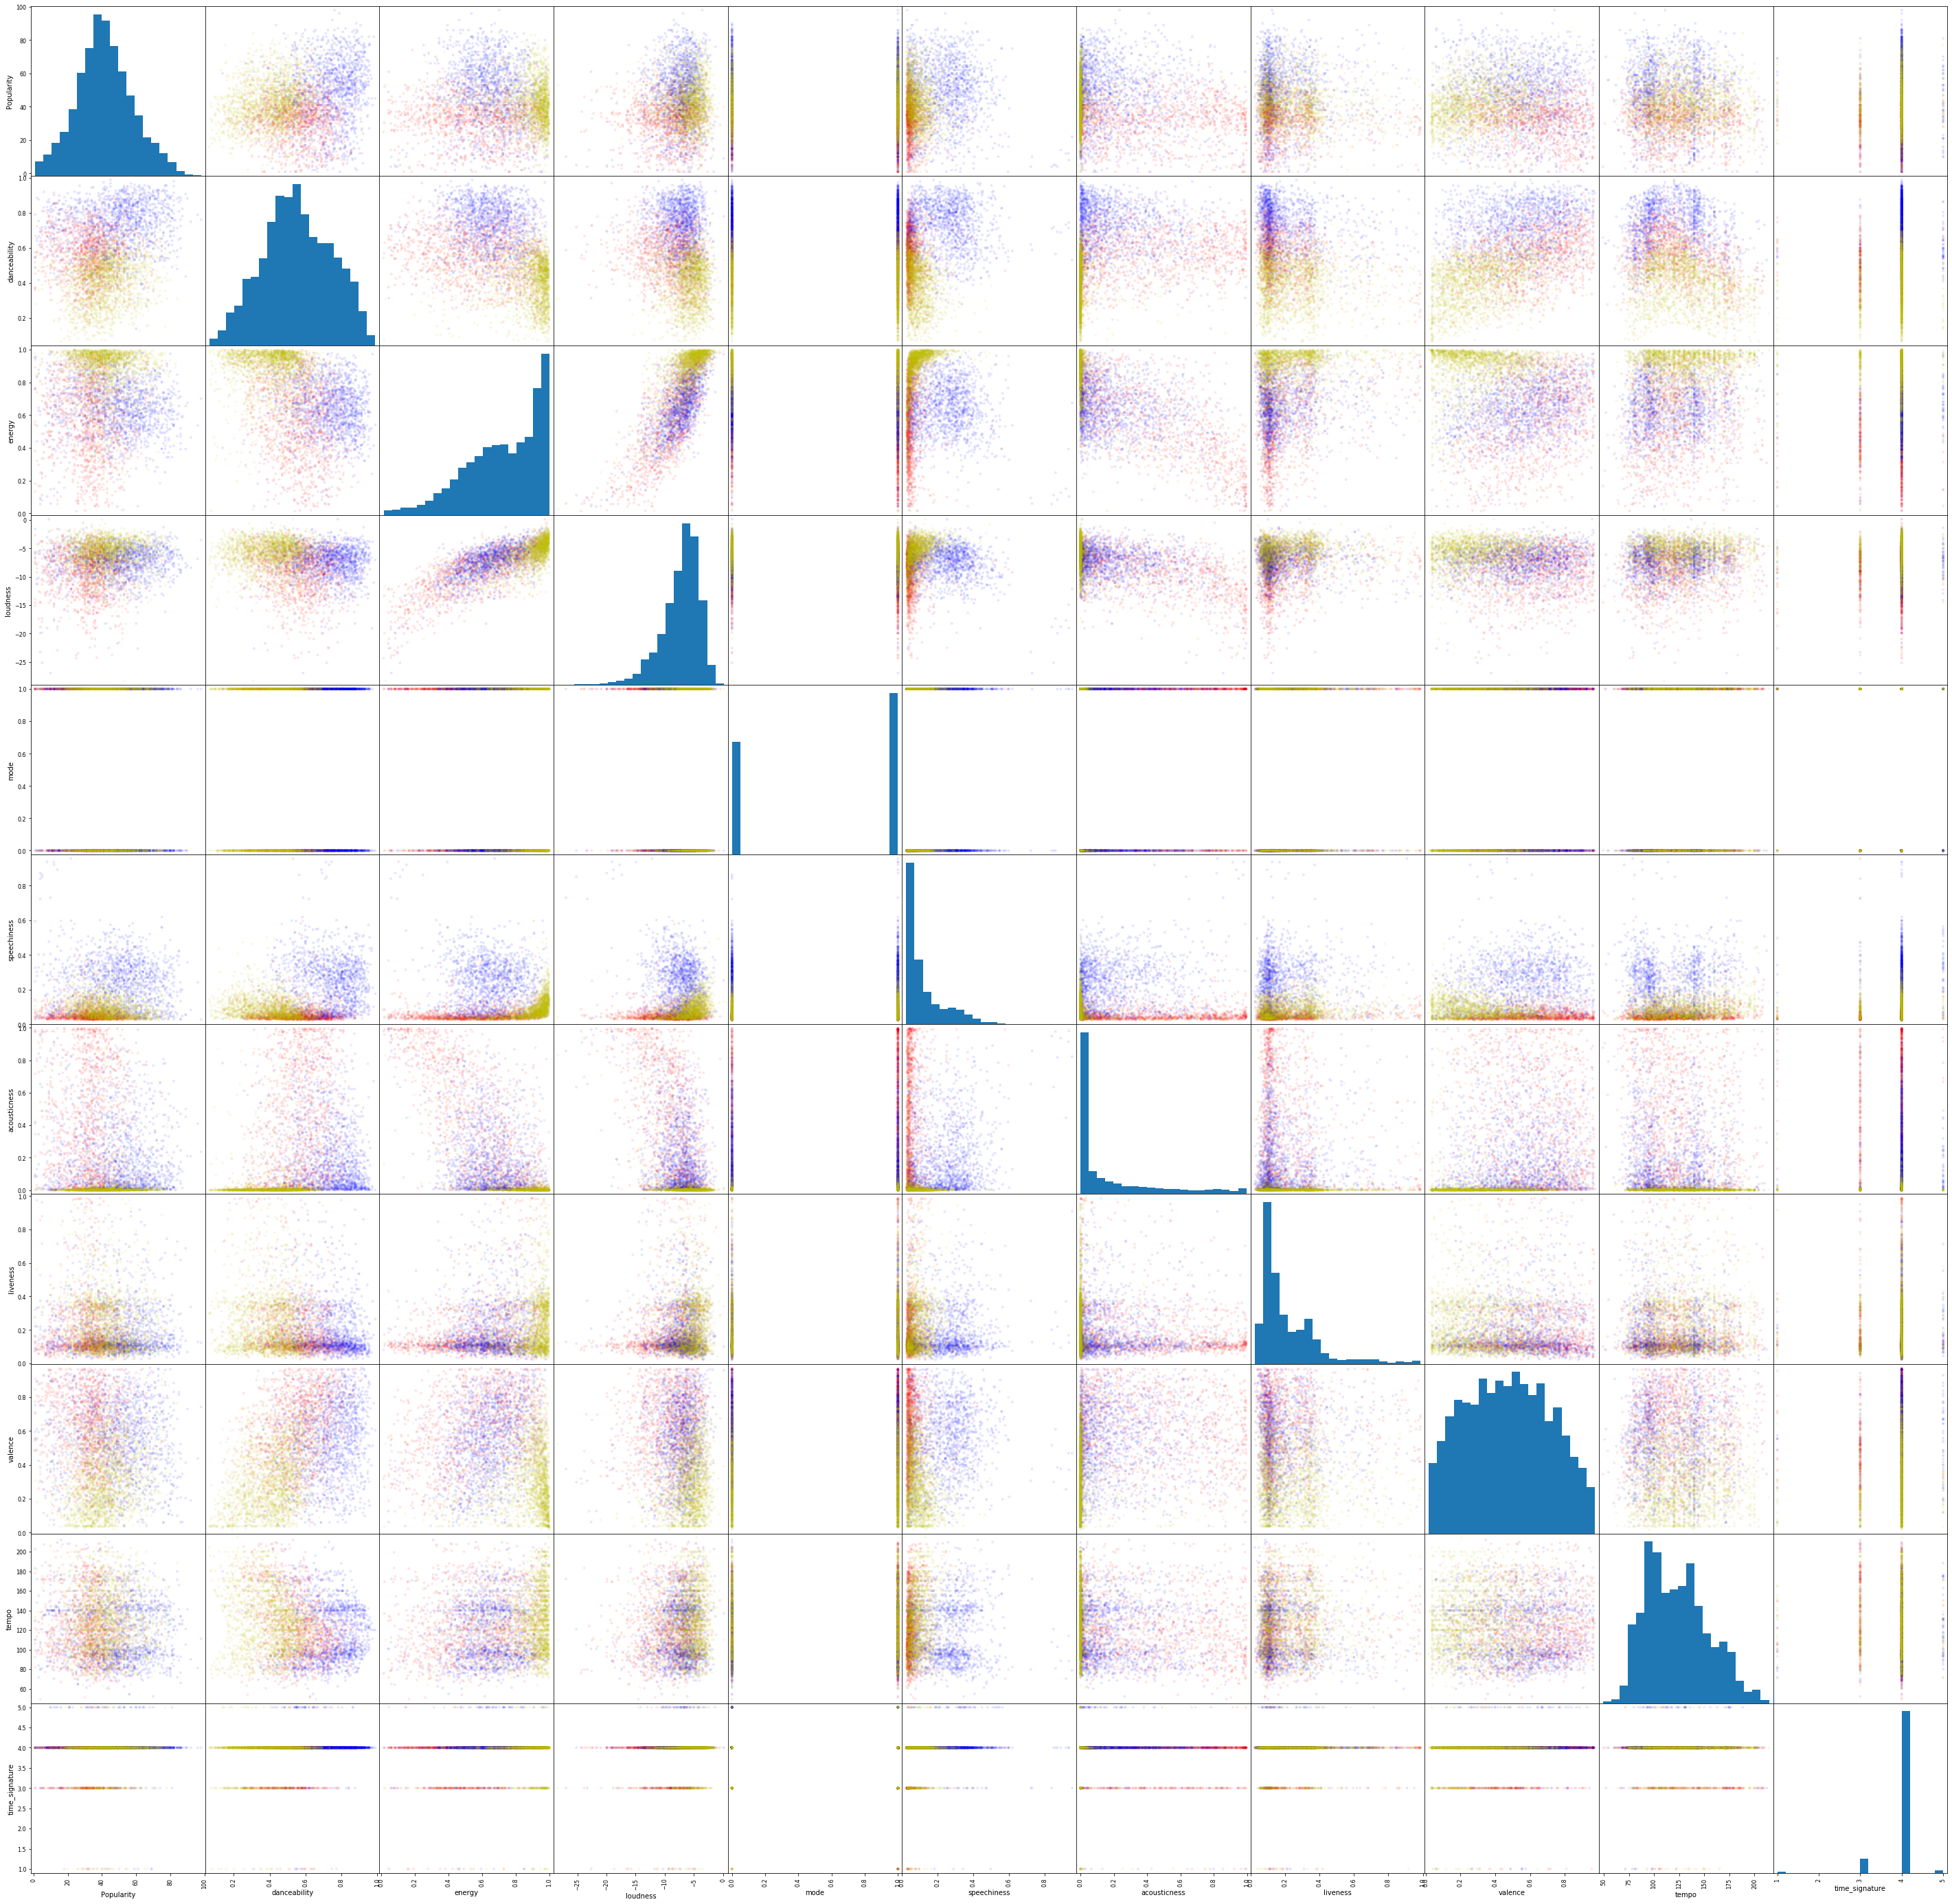

In [5]:
# scatter matrix
color_map = {2:'r', 5:'b', 8:'y'}
colors = [color_map[yn] for yn in y]
pd.plotting.scatter_matrix(X, c=colors, figsize=(50, 50), hist_kwds={'bins': 20}, s=60, alpha=.1)

## KNN

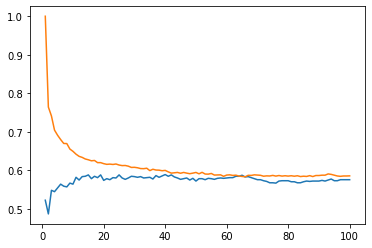

In [6]:
train_scores = []
test_scores = []
max_k = 100
for i in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    test_scores.append(knn.score(X_test,y_test))
    train_scores.append(knn.score(X_train,y_train))

plt.plot([i for i in range(1, max_k + 1)], test_scores)  # Blue
plt.plot([i for i in range(1, max_k + 1)], train_scores) # Orange

At about 20 neighbors, the accuracy for the test dataset plateaus at around 60% accuracy, which is okay. However, at only a few neighbors, the model was prone to extremem overfitting. What if we reduced the dimmensionality of X, as the data is pretty sparse? Looking at the graphs of the features, speechiness, loudness, danceability, acousticness, and popularity seem to vary a fair amount among the classes.

(3377, 5)
(3377,)


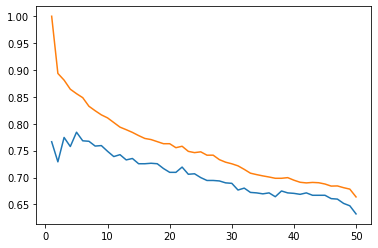

In [7]:
X_train_reduced = X_train[["Popularity", "danceability", "valence", "speechiness", "acousticness"]]
print(X_train_reduced.shape)
print(y_train.shape)

max_k = 50
train_scores = []
test_scores = []
for i in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_reduced, y_train)
    test_scores.append(knn.score(X_test[["Popularity", "danceability", "valence", "speechiness", "acousticness"]],y_test))
    train_scores.append(knn.score(X_train_reduced[["Popularity", "danceability", "valence", "speechiness", "acousticness"]],y_train))

plt.plot([i for i in range(1, max_k + 1)], test_scores)  # Blue
plt.plot([i for i in range(1, max_k + 1)], train_scores) # Orange

Much better with fewer components! Let's also try PCA in addition to reducing the dimmensionality, using a range of values for K. (This one takes a very long time to run.) We also tried PCA with all attributes included, but more components were needing to represent the data.

In [8]:
# Normalize the data
X_reduced = X[["Popularity", "danceability", "valence", "speechiness", "acousticness"]]
scaler = StandardScaler()
scaler.fit(X_reduced)
X_scaled = scaler.transform(X_reduced)

In [12]:
max_pc = 5 # D = 5
max_k = 75

for i in range(1, max_pc + 1):
    # Do PCA with i components
    pca = PCA(n_components=i)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y)
    
    # Try different k
    scores = []
    for k in range(1, max_k + 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_pca, y_train_pca)
        scores.append(knn.score(X_test_pca,y_test_pca))

    plt.plot([i for i in range(1, max_k + 1)], scores, label=i)
plt.legend()

Now, at around 6-7 principal components and 20 neighbors, KNN's scores plateau around 47-52%, a good improvement. Interestingly, using PCA to transform the data to a same-sized space (D = 11) improves the performance of KNN and reduced the number of neighbors needed to produce the same accuracy. This is likely because the principal components each select the most influential features, thus helping to separate clustered data. 

Here's a KNN model for reference against the other models we will develop.

In [9]:
pca = PCA(n_components=3)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train_pca)
print("Test Score: ", knn.score(X_test_pca, y_test_pca), "\nTrain Score: ", knn.score(X_train_pca, y_train_pca))

Test Score:  0.8587921847246892 
Train Score:  0.8655611489487711


What classes are being misclassified?

In [10]:
y_test_classify = knn.predict(X_test_pca)
incorrect = Counter(y_test_pca[y_test_pca != y_test_classify])
perclass = Counter(y_test_pca)

print("Percent in test set misclassified:")
for key in incorrect:
    print(classes[key], incorrect[key] / perclass[key])

Percent in test set misclassified:
Metal 0.1076923076923077
Blues 0.17791411042944785
HipHop 0.15072463768115943


# Logistic Regression

Let's try training a logistic regression multi-class classifier using one versus rest, using all the features of the data.

In [11]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y)

log_reg = LogisticRegression(multi_class="ovr",solver="liblinear", C=10)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
y_train_classify = log_reg.predict(X_train_scaled)
y_test_classify = log_reg.predict(X_test_scaled)

accuracy = np.sum(y_test_classify == y_test)
accuracy_train = np.sum(y_train_classify == y_train)
print("Accuracy on test: " + str(accuracy / len(y_test)))
print("Accuracy on train: " + str(accuracy_train / len(y_train)))

Accuracy on test: 0.8801065719360568
Accuracy on train: 0.8803671898134439


In [13]:
print("Training set score: {:.3f}".format(log_reg.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(log_reg.score(X_test_scaled, y_test)))

Training set score: 0.880
Test set score: 0.880


That's pretty good! What is the result when we switch to softmax?

In [14]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X_scaled, y)

print("Training set score: {:.3f}".format(softmax_reg.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(softmax_reg.score(X_test_scaled, y_test)))

Training set score: 0.882
Test set score: 0.881


I suppose that is a tiny tiny bit better.

Looks like logistic regression is getting us a pretty consistent 88%

Let us see what happens when we adjust C

In [16]:
print("C = 1 (default)")
softmax_reg1 = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=1)
softmax_reg1.fit(X_scaled, y)
print("Training set score: {:.3f}".format(softmax_reg1.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(softmax_reg1.score(X_test_scaled, y_test)))

print("C = 100")
softmax_reg100 = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=100)
softmax_reg100.fit(X_scaled, y)
print("Training set score: {:.3f}".format(softmax_reg100.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(softmax_reg100.score(X_test_scaled, y_test)))

print("C = 0.01")
softmax_reg001 = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=0.01)
softmax_reg001.fit(X_scaled, y)
print("Training set score: {:.3f}".format(softmax_reg001.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(softmax_reg001.score(X_test_scaled, y_test)))

C = 1 (default)
Training set score: 0.882
Test set score: 0.882
C = 100
Training set score: 0.882
Test set score: 0.881
C = 0.01
Training set score: 0.877
Test set score: 0.880


Not all that helpful :(

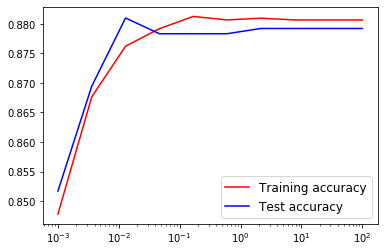

In [17]:
c_vals = np.logspace(-3, 2, num=10, base=10)
#c_vals = [1.]
regs = [LogisticRegression(multi_class="multinomial", solver="lbfgs", C=c).fit(X_train_scaled, y_train) for c in c_vals]
train_accs = np.array([lg.score(X_train_scaled, y_train) for lg in regs])
test_accs = np.array([lg.score(X_test_scaled, y_test) for lg in regs])
plt.xscale("log")
plt.plot(c_vals, train_accs, "r-", label="Training accuracy")
plt.plot(c_vals, test_accs, "b-", label="Test accuracy")
plt.legend(loc="lower right", fontsize=12)

# Support Vector Machines

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import mglearn

/usr/local/lib64/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


A quick preliminary run of SVM on our data

In [19]:
svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.74
Accuracy on test set: 0.38


Training set did okay, but with the high training set score, this looks like a classic case of overfitting. What happens if we use our scaled data instead?

In [20]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scaled, y_test)))

/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.92
Accuracy on test set: 0.90


Now that's more like it!

What happens if we adjust C? A larger C will usually mean fewer misclassification on the training set

In [23]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.996
Accuracy on test set: 0.848


Well that did help the training set, but the cost to the test set accuracy is not worth the trade. Can we mess around with C and boost the test set any more?

In [25]:
print("C = 0.01")
svc = SVC(C=0.01)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

print("C = 1 (default)")
svc = SVC(C=1)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

print("C = 100")
svc = SVC(C=100)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

print("C = 500")
svc = SVC(C=500)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

C = 0.01


/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.843
Accuracy on test set: 0.856
C = 1 (default)


/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.917
Accuracy on test set: 0.903
C = 100


/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.977
Accuracy on test set: 0.871
C = 500


/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.993
Accuracy on test set: 0.850


/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The 

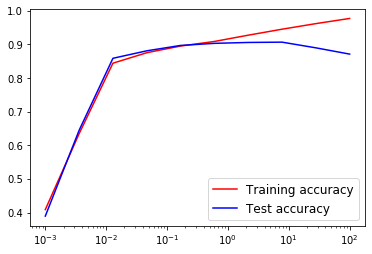

In [27]:
c_vals = np.logspace(-3, 2, num=10, base=10)
#c_vals = [1.]
regs = [SVC(C=c).fit(X_train_scaled, y_train) for c in c_vals]
train_accs = np.array([svc.score(X_train_scaled, y_train) for svc in regs])
test_accs = np.array([svc.score(X_test_scaled, y_test) for svc in regs])
plt.xscale("log")
plt.plot(c_vals, train_accs, "r-", label="Training accuracy")
plt.plot(c_vals, test_accs, "b-", label="Test accuracy")
plt.legend(loc="lower right", fontsize=12)

Looks like the test set accuracy maxes out at a C value of about 10. Let's run SVC once more with C=10

In [29]:
svc = SVC(C=10)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.946
Accuracy on test set: 0.903


90.3%    There you have it folks!